In [39]:
import pandas as pd
import numpy as np
from pymoo.algorithms.nsga3 import NSGA3
from pymoo.algorithms.unsga3 import UNSGA3
from pymoo.factory import get_reference_directions
import pickle
from pymoo.optimize import minimize
from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination
from contact_problem import ContactProblemDownSelect

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
prefix = 'eo_' + 'telesat_'

case, target = pickle.load(open('raw/%ssettings.pkl' % prefix, 'rb'))

import util
util.print_targets(case)

Targets per orbit
T_target: 960.00 Gb (min: 624.00 Gb, max: 1296.00 Gb)
L_target: 0.00 s
E_target: 41.16 kJ (max: -0.00 kJ)
P_target: 0.00 s


In [41]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "raw/%spost_processed.h5" % prefix

row_limit = -1

store = pd.HDFStore(file_path)

instances_df = store.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_df = instances_df.sort_index(0)

In [ ]:
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters

sys_param = SystemParameters()
sys_param.fc_Hz = target['frequency']
sys_param.GT_dBK = target['GT_dBK']
sys_param.margin_dB = 3.0
sys_param.B_Hz_array = np.array([0.1, 0.5, 1, 10, 50, 100, 200, 300]) * 1e6
sys_param.Gtx_dBi_bounds = (3., 43.)
sys_param.Ptx_dBm_bounds = (20., 43.)

modcods_df = pd.read_pickle('../dvbs2.pkl')

sys_param.EsN0_req_dB_array = modcods_df[['isend', 'isend_200MHz', 'isend_300MHz']].to_numpy()
sys_param.eta_bitsym_array = modcods_df[['eta', 'eta_200MHz', 'eta_300MHz']].to_numpy()
sys_param.eta_maee_array = modcods_df[['maee_12', 'maee_12_200MHz', 'maee_12_300MHz']].to_numpy()

In [44]:
settings = {}

# NSGA-III
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=8)
pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4)

n_partitions=199
plot = True

init_problem = ContactProblemDownSelect(instances_df, sys_param)
sampling, crossover, mutation = design_vector_default_scm(init_problem.x_length, init_problem.x_indices)

# NGSA-III optimization
from pymoo.factory import get_reference_directions
init_ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=n_partitions)
init_pop_size = int(np.ceil(len(init_ref_dirs) / 100) * 100)
init_n_offsprings = int(np.ceil(len(init_ref_dirs) / 100) * 100 / 2)
init_pop_size = 400
init_n_offsprings = 200

print("init_ref_dirs: %d" % len(init_ref_dirs))
print("init_pop_size: %d" % init_pop_size)
print("init_n_offsprings: %d" % init_n_offsprings)

algorithm = UNSGA3(
    pop_size=init_pop_size,
    n_offsprings=init_n_offsprings,
    sampling=np.zeros((init_pop_size, init_problem.x_length)),
    crossover=crossover,
    mutation=mutation,
    ref_dirs=init_ref_dirs,
    eliminate_duplicates=False,
)

termination = MultiObjectiveSpaceToleranceTermination(tol=0.0001,
                                                      n_last=50,
                                                      nth_gen=10,
                                                      n_max_gen=2500,
                                                      n_max_evals=None)
termination = ('n_gen', 1000)

print("Running initial conditions optimization...")
init_res = minimize(init_problem,
                    algorithm,
                    termination,
                    seed=1,
                    verbose=True,
                    copy_algorithm=False,
                    )

x_pass, _, _, _ = util.get_selection(init_problem, init_res)

init_ref_dirs: 100
init_pop_size: 400
init_n_offsprings: 200
Running initial conditions optimization...
    1 |     400 |       1 |  5.09100E+03 |        ideal
    2 |     600 |       8 |  1.000000000 |        ideal
    3 |     800 |       9 |  0.049045762 |        ideal
    4 |    1000 |      10 |  0.205575481 |        ideal
    5 |    1200 |       8 |  0.036790858 |            f
    6 |    1400 |       8 |  0.00000E+00 |            f
    7 |    1600 |       8 |  0.000917020 |            f
    8 |    1800 |       7 |  0.005822349 |            f
    9 |    2000 |      10 |  0.038177169 |            f
   10 |    2200 |      11 |  0.010022325 |            f
   11 |    2400 |      13 |  0.019406034 |            f
   12 |    2600 |      11 |  0.157995882 |        ideal
   13 |    2800 |      13 |  0.033138274 |            f
   14 |    3000 |      13 |  0.00000E+00 |            f
   15 |    3200 |      12 |  0.020773600 |            f
   16 |    3400 |       9 |  0.00000E+00 |            f


Plotting 28 results


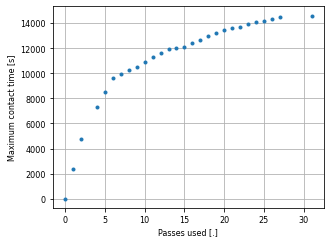

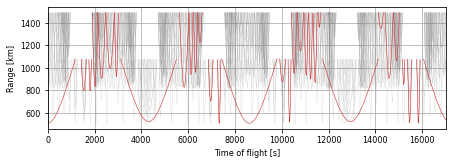

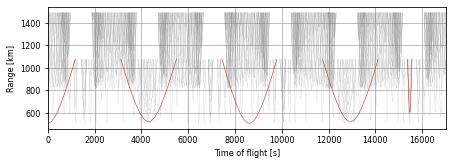

In [45]:
print("Plotting %d results" % len(init_res.X))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(init_res.F[:, 1], init_res.F[:, 0] * -1, marker='.')
ax.set_xlabel('Passes used [.]')
ax.set_ylabel('Maximum contact time [s]')
ax.grid()
from pyreport import PlotUtil
PlotUtil.apply_report_formatting_single()
plt.tight_layout()
fig.savefig('D:/git/thesis_report_ae/figures/relay_optimization/biased_telesat.pdf')

util.plot_used_passes(case, instances_df, init_problem, init_res.X[np.argmin(init_res.F[:, 0]), :], usefull_only = False)

i = init_res.F[:, 1] == 5

util.plot_used_passes(case, instances_df, init_problem, init_res.X[i, :], usefull_only = False)

# settings = {}
#
# ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=23)
# pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
# n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4)
#
# biased_init = max_contact_biased_rnsga2(instances_df, sys_param, case, pop_size)

In [46]:
from beepy import beep
for i in range(3):
    beep(sound=5)
